### import data

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, MaxNLocator

%matplotlib inline
%store -r sc_customers
%store -r sc_products
%store -r sc_categories_departments
%store -r sc_orders
%store -r sc_orders_ratio
%store -r sc_orders_demographic
%store -r sc_shipping

In [2]:
all_column_name = (
    sc_customers.columns.tolist() +
    sc_products.columns.tolist() +
    sc_categories_departments.columns.tolist() +
    sc_orders.columns.tolist() +
    sc_orders_demographic.columns.tolist() +
    sc_shipping.columns.tolist()
    )
all_column_name

['customer_id',
 'first_name',
 'last_name',
 'segment',
 'country',
 'state',
 'city',
 'street',
 'zipcode',
 'product_id',
 'product_name',
 'category_id',
 'department_id',
 'price',
 'product_image',
 'category_id',
 'category',
 'department_id',
 'department',
 'order_id',
 'transaction_id',
 'customer_id',
 'order_date',
 'payment_type',
 'product_id',
 'price',
 'quantity',
 'gross_sale',
 'discount_pct',
 'discount',
 'net_sale',
 'order_id',
 'transaction_id',
 'order_date',
 'type',
 'customer_id',
 'latitiude',
 'longitude',
 'market',
 'region',
 'country',
 'state',
 'city',
 'zipcode',
 'order_status',
 'order_id',
 'transaction_id',
 'order_date',
 'customer_id',
 'product_id',
 'shipping_date',
 'mode',
 'days_shipping_scheduled',
 'days_shipping_real',
 'delivery_status',
 'risk']

# Request 1
## Analyze the relationship between the 'days_shipping_real' and the 'risk.'

## Investigate whether orders with longer shipping durations are more likely to be at risk of late delivery.

## Additionally, break down the analysis by different product categories to see if the relationship varies across product types.

## Provide insights into potential factors contributing to late deliveries based on the shipping duration and product categories.

In [3]:
sc_shipping

,order_id,transaction_id,order_date,customer_id,product_id,shipping_date,mode,days_shipping_scheduled,days_shipping_real,delivery_status,risk
0,44371,110769,2016-10-09 16:47:00,7537,627,2016-10-10 04:47:00,Same Day,0,1,Late delivery,1
1,18065,45146,2015-09-21 16:37:00,1521,1014,2015-09-27 16:37:00,Standard Class,4,6,Late delivery,1
2,33158,82891,2016-04-29 00:22:00,5849,502,2016-05-01 00:22:00,First Class,1,2,Late delivery,1
3,73677,176992,2017-12-11 11:59:00,4848,1362,2017-12-14 11:59:00,Standard Class,4,3,Advance shipping,0
4,5834,14520,2015-03-27 03:33:00,4515,1004,2015-04-01 03:33:00,Standard Class,4,5,Late delivery,1
...,...,...,...,...,...,...,...,...,...,...,...
180514,8364,20897,2015-05-03 01:55:00,4038,1004,2015-05-08 01:55:00,Second Class,2,5,Late delivery,1
180515,14594,36501,2015-08-02 00:34:00,698,502,2015-08-07 00:34:00,Standard Class,4,5,Late delivery,1
180516,38897,97110,2016-07-21 19:00:00,290,403,2016-07-24 19:00:00,Second Class,2,3,Late delivery,1
180517,66417,166028,2017-08-27 12:28:00,11978,957,2017-08-30 12:28:00,Standard Class,4,3,Advance shipping,0


In [4]:
sc_shipping[(sc_shipping['delivery_status'] == 'Late delivery') & (sc_shipping['days_shipping_real'] == 3)].count()

order_id                   6759
transaction_id             6759
order_date                 6759
customer_id                6759
product_id                 6759
shipping_date              6759
mode                       6759
days_shipping_scheduled    6759
days_shipping_real         6759
delivery_status            6759
risk                       6759
dtype: int64

### what does risk mean? risk is defined by whether or not a delivery was late. 1= late and 0 = not late

In [5]:
sc_shipping['risk'].value_counts()[1]

98977

In [6]:
sc_shipping['delivery_status'].value_counts()['Late delivery']

98977

In [7]:
sc_shipping[(sc_shipping['delivery_status'] == 'Late delivery') & (sc_shipping['risk'] == 1)]['risk'].value_counts()

1    98977
Name: risk, dtype: int64

### A correlation coefficient of 0.401415 indicates a positive correlation between two variables, but the strength of the correlation is moderate.

In [8]:
sc_shipping[['days_shipping_real', 'risk']].corr()

,days_shipping_real,risk
days_shipping_real,1.000000,0.401415
risk,0.401415,1.000000


### aggregate shipments by delivery status, display in a barplot

In [9]:
sc_shipping['delivery_status'].drop_duplicates()

0         Late delivery
3      Advance shipping
11     Shipping on time
15    Shipping canceled
Name: delivery_status, dtype: object

In [10]:
shipping_pivot = sc_shipping.pivot_table(index='days_shipping_real', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot= shipping_pivot[['days_shipping_real', 'Advance shipping', 'Shipping canceled', 'Late delivery', 'Shipping on time']]
shipping_pivot

delivery_status,days_shipping_real,Advance shipping,Shipping canceled,Late delivery,Shipping on time
0,0,0,241,0,4839
1,1,0,203,4454,0
2,2,20873,2413,26513,6819
3,3,20719,1287,6759,0
4,4,0,1216,6759,20538
5,5,0,1160,27003,0
6,6,0,1234,27489,0


In [11]:
shipping_pivot.columns = ['days_shipping_real', 'n_advanced', 'n_cancelled', 'n_late', 'n_on_time']
shipping_pivot = shipping_pivot[['days_shipping_real', 'n_advanced', 'n_on_time', 'n_late', 'n_cancelled']]
shipping_pivot

,days_shipping_real,n_advanced,n_on_time,n_late,n_cancelled
0,0,0,4839,0,241
1,1,0,0,4454,203
2,2,20873,6819,26513,2413
3,3,20719,0,6759,1287
4,4,0,20538,6759,1216
5,5,0,0,27003,1160
6,6,0,0,27489,1234


total = sc_shipping.groupby('days_shipping_real')['delivery_status'].count().reset_index(name='total')
total

shipping_merge = shipping_pivot.merge(total, on='days_shipping_real')

shipping_merge = shipping_merge[['days_shipping_real', 'total', 'n_advanced', 'n_on_time', 'n_late', 'n_cancelled']]
shipping_merge

In [12]:
stains = [
 'blue : #578C1D',
 'green : #22A3CF',
 'red : #FF614E']

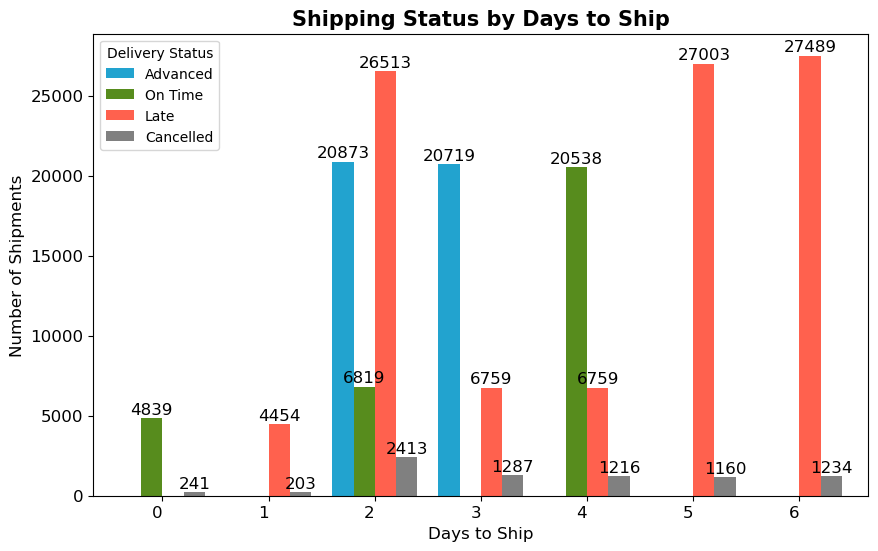

In [13]:
ax = shipping_pivot.plot(kind='bar', x='days_shipping_real', stacked=False, figsize=(10, 6), width=0.8, color=['#22A3CF', '#578C1D', '#FF614E', 'grey'])

plt.title('Shipping Status by Days to Ship', fontsize=15, fontweight='bold')
plt.xlabel('Days to Ship', fontsize=12)
plt.ylabel('Number of Shipments', fontsize=12)
plt.legend(title='Delivery Status', labels=['Advanced', 'On Time', 'Late', 'Cancelled'], title_fontsize=10, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=12)

In [14]:
total = sc_shipping.groupby('days_shipping_real')['delivery_status'].count().reset_index(name='total')
total

,days_shipping_real,total
0,0,5080
1,1,4657
2,2,56618
3,3,28765
4,4,28513
5,5,28163
6,6,28723


In [15]:
shipping_merge = shipping_pivot.merge(total, on='days_shipping_real')
shipping_merge = shipping_merge[['days_shipping_real', 'total', 'n_advanced', 'n_on_time', 'n_late', 'n_cancelled']]
shipping_merge

,days_shipping_real,total,n_advanced,n_on_time,n_late,n_cancelled
0,0,5080,0,4839,0,241
1,1,4657,0,0,4454,203
2,2,56618,20873,6819,26513,2413
3,3,28765,20719,0,6759,1287
4,4,28513,0,20538,6759,1216
5,5,28163,0,0,27003,1160
6,6,28723,0,0,27489,1234


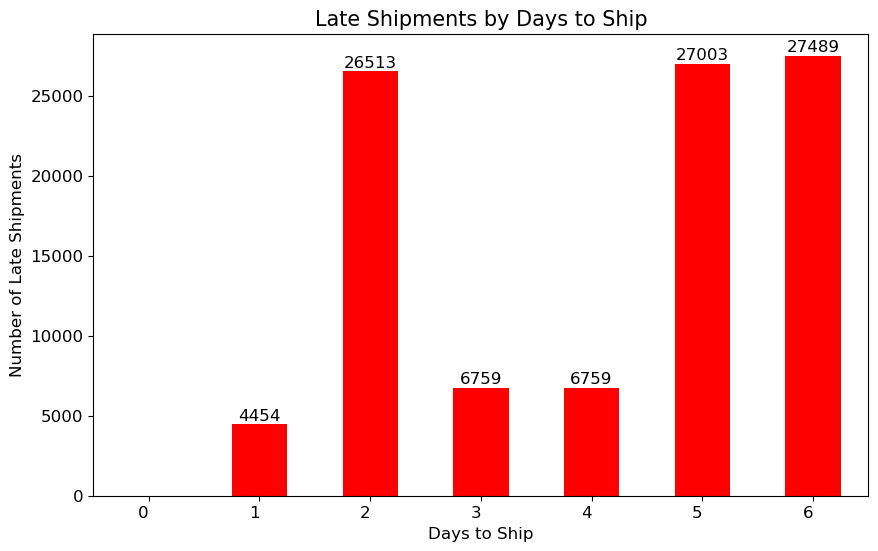

In [16]:
ax = shipping_merge['n_late'].plot(kind='bar', x='days_shipping_real', stacked=False, figsize=(10, 6), color='red')

plt.title('Late Shipments by Days to Ship', fontsize=15)
plt.xlabel('Days to Ship', fontsize=12)
plt.ylabel('Number of Late Shipments', fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=12)

### aggregate shipments by delivery status, display in a pie plot

In [17]:
shipping_merge

,days_shipping_real,total,n_advanced,n_on_time,n_late,n_cancelled
0,0,5080,0,4839,0,241
1,1,4657,0,0,4454,203
2,2,56618,20873,6819,26513,2413
3,3,28765,20719,0,6759,1287
4,4,28513,0,20538,6759,1216
5,5,28163,0,0,27003,1160
6,6,28723,0,0,27489,1234


In [18]:
shipping_melt = pd.melt(shipping_merge, id_vars=['days_shipping_real'], var_name='delivery_status', value_name='value')
shipping_melt

,days_shipping_real,delivery_status,value
0,0,total,5080
1,1,total,4657
2,2,total,56618
3,3,total,28765
4,4,total,28513
5,5,total,28163
6,6,total,28723
7,0,n_advanced,0
8,1,n_advanced,0
9,2,n_advanced,20873


In [19]:
shipping_pie = shipping_melt.pivot(index='delivery_status', columns='days_shipping_real', values='value').reset_index().rename_axis(columns=None)
shipping_pie

,delivery_status,0,1,2,3,4,5,6
0,n_advanced,0,0,20873,20719,0,0,0
1,n_cancelled,241,203,2413,1287,1216,1160,1234
2,n_late,0,4454,26513,6759,6759,27003,27489
3,n_on_time,4839,0,6819,0,20538,0,0
4,total,5080,4657,56618,28765,28513,28163,28723


In [20]:
shipping_pie = shipping_pie.rename(columns={0:'0_days_to_ship', 1:'1_days_to_ship', 2:'2_days_to_ship', 3:'3_days_to_ship', 4:'4_days_to_ship', 5:'5_days_to_ship', 6:'6_days_to_ship'})
shipping_pie

,delivery_status,0_days_to_ship,1_days_to_ship,2_days_to_ship,3_days_to_ship,4_days_to_ship,5_days_to_ship,6_days_to_ship
0,n_advanced,0,0,20873,20719,0,0,0
1,n_cancelled,241,203,2413,1287,1216,1160,1234
2,n_late,0,4454,26513,6759,6759,27003,27489
3,n_on_time,4839,0,6819,0,20538,0,0
4,total,5080,4657,56618,28765,28513,28163,28723


In [21]:
stains = ['blue : #578C1D', 'green : #22A3CF', 'red : #FF614E, yellow : #DBE363']
stains

['blue : #578C1D', 'green : #22A3CF', 'red : #FF614E, yellow : #DBE363']

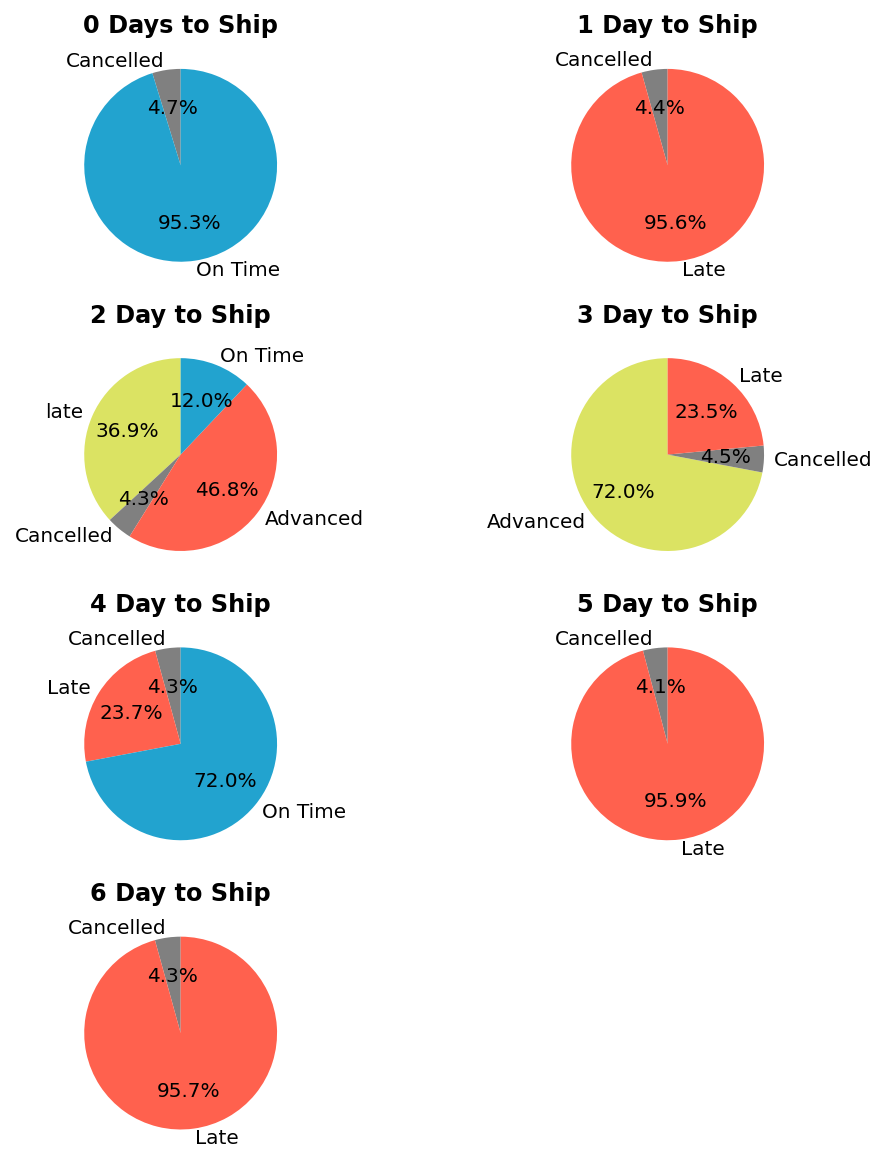

In [22]:
fig = plt.figure(figsize=(8, 10),dpi=144)

ax1 = fig.add_subplot(4, 2, 1)
ax1.pie(shipping_pie['0_days_to_ship'].drop(index=[4, 2, 0]), autopct='%1.1f%%', startangle=90, colors=['grey', '#22A3CF'], labels=['Cancelled', 'On Time'])
ax1.set_title('0 Days to Ship', fontsize=12, fontweight='bold')

ax2 = fig.add_subplot(4, 2, 2)
ax2.pie(shipping_pie['1_days_to_ship'].drop(index=[4, 0, 3]), autopct='%1.1f%%', startangle=90, colors=['grey', '#FF614E'], labels=['Cancelled', 'Late'])
ax2.set_title('1 Day to Ship', fontsize=12, fontweight='bold')

ax3 = fig.add_subplot(4, 2, 3)
ax3.pie(shipping_pie['2_days_to_ship'].drop(index=[4]), autopct='%1.1f%%', startangle=90, colors=['#DBE363', 'grey', '#FF614E', '#22A3CF'], labels=['late', 'Cancelled', 'Advanced', 'On Time'])
ax3.set_title('2 Day to Ship', fontsize=12, fontweight='bold')

ax4 = fig.add_subplot(4, 2, 4)
ax4.pie(shipping_pie['3_days_to_ship'].drop(index=[4, 3]), autopct='%1.1f%%', startangle=90, colors=['#DBE363', 'grey', '#FF614E'], labels=['Advanced', 'Cancelled', 'Late',])
ax4.set_title('3 Day to Ship', fontsize=12, fontweight='bold')

ax5 = fig.add_subplot(4, 2, 5)
ax5.pie(shipping_pie['4_days_to_ship'].drop(index=[4, 0]), autopct='%1.1f%%', startangle=90, colors=['grey', '#FF614E', '#22A3CF'], labels=['Cancelled', 'Late', 'On Time'])
ax5.set_title('4 Day to Ship', fontsize=12, fontweight='bold')

ax6 = fig.add_subplot(4, 2, 6)
ax6.pie(shipping_pie['5_days_to_ship'].drop(index=[4, 0, 3]), autopct='%1.1f%%', startangle=90, colors=['grey', '#FF614E'], labels=['Cancelled', 'Late'])
ax6.set_title('5 Day to Ship', fontsize=12, fontweight='bold')

ax7 = fig.add_subplot(4, 2, 7)
ax7.pie(shipping_pie['6_days_to_ship'].drop(index=[4, 0, 3]), autopct='%1.1f%%', startangle=90, colors=['grey', '#FF614E'], labels=['Cancelled', 'Late'])
ax7.set_title('6 Day to Ship', fontsize=12, fontweight='bold')

plt.show()

### incorporate product catagories into analysis

In [23]:
shipping_merge = sc_shipping.merge(sc_products, on='product_id').merge(sc_categories_departments, on='category_id')
shipping_merge = shipping_merge[['order_id', 'transaction_id', 'order_date', 'days_shipping_real', 'delivery_status', 'risk', 'product_id', 'product_name', 'category', 'department']]
shipping_merge

,order_id,transaction_id,order_date,days_shipping_real,delivery_status,risk,product_id,product_name,category,department
0,44371,110769,2016-10-09 16:47:00,1,Late delivery,1,627,Under Armour Girls' Toddler Spine Surge Runni,Shop By Sport,Golf
1,14096,35269,2015-07-25 18:06:00,2,Advance shipping,0,627,Under Armour Girls' Toddler Spine Surge Runni,Shop By Sport,Golf
2,57645,144199,2017-04-21 11:15:00,6,Late delivery,1,627,Under Armour Girls' Toddler Spine Surge Runni,Shop By Sport,Golf
3,3440,8551,2015-02-20 04:50:00,0,Shipping on time,0,627,Under Armour Girls' Toddler Spine Surge Runni,Shop By Sport,Golf
4,35310,88185,2016-05-30 10:18:00,6,Late delivery,1,627,Under Armour Girls' Toddler Spine Surge Runni,Shop By Sport,Golf
...,...,...,...,...,...,...,...,...,...,...
180514,62772,156939,2017-07-05 07:28:00,2,Late delivery,1,359,Nike Men's Free TR 5.0 TB Training Shoe,As Seen on TV!,Footwear
180515,62546,156317,2017-07-02 00:17:00,2,Shipping canceled,0,359,Nike Men's Free TR 5.0 TB Training Shoe,As Seen on TV!,Footwear
180516,59667,149324,2017-05-20 23:39:00,3,Advance shipping,0,359,Nike Men's Free TR 5.0 TB Training Shoe,As Seen on TV!,Footwear
180517,66574,166404,2017-08-29 19:29:00,5,Late delivery,1,359,Nike Men's Free TR 5.0 TB Training Shoe,As Seen on TV!,Footwear


In [24]:
shipping_group = shipping_merge.groupby('category')
correlation_results = shipping_group[['days_shipping_real', 'risk']].corr().unstack()['days_shipping_real']['risk']
print('pct_late mean:', correlation_results.mean())
print('pct_late std:', correlation_results.std())
print('pct_late one std:', correlation_results.std() + correlation_results.mean())
correlation_results.sort_values(ascending=False)

pct_late mean: 0.4009439075766828
pct_late std: 0.05485351702775462
pct_late one std: 0.4557974246044374


category
Men's Golf Clubs        0.525869
Soccer                  0.514905
Computers               0.487100
Basketball              0.485297
As Seen on  TV!         0.481512
Children's Clothing     0.478782
Women's Golf Clubs      0.467561
Video Games             0.454856
Trade-In                0.450719
Tennis & Racquet        0.450130
Golf Apparel            0.445377
DVDs                    0.436779
Women's Clothing        0.427681
Kids' Golf Clubs        0.415366
Golf Balls              0.409918
Camping & Hiking        0.408406
Golf Gloves             0.407435
Men's Footwear          0.404785
Garden                  0.404513
Toys                    0.403515
Indoor/Outdoor Games    0.403116
Cleats                  0.403066
Fishing                 0.402443
Cardio Equipment        0.401838
Electronics             0.401671
Strength Training       0.401453
Shop By Sport           0.398704
Accessories             0.398501
Water Sports            0.396978
Women's Apparel         0.395659
C

In [25]:
shipping_merge['category'].value_counts()

Cleats                  24551
Men's Footwear          22246
Women's Apparel         21035
Indoor/Outdoor Games    19298
Fishing                 17325
Water Sports            15540
Camping & Hiking        13729
Cardio Equipment        12487
Shop By Sport           10984
Electronics              3156
Accessories              1780
Golf Balls               1475
Girls' Apparel           1201
Golf Gloves              1070
Trade-In                  974
Video Games               838
Children's Clothing       652
Women's Clothing          650
Baseball & Softball       632
Hockey                    614
Cameras                   592
Toys                      529
Golf Shoes                524
Pet Supplies              492
Garden                    484
Crafts                    484
DVDs                      483
Computers                 442
Golf Apparel              441
Hunting & Shooting        440
Music                     434
Consumer Electronics      431
Boxing & MMA              423
Books     

### aggregate shipments by delivery status, days to ship and product category, display in a heatmap

In [26]:
shipping_pivot_all = shipping_merge.pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_all.columns = ['category', 'n_advanced', 'n_late', 'n_cancelled', 'n_on_time']
shipping_pivot_all['total'] = shipping_pivot_all['n_advanced'] + shipping_pivot_all['n_on_time'] + shipping_pivot_all['n_cancelled'] + shipping_pivot_all['n_late']
shipping_pivot_all['n_not_late'] = shipping_pivot_all['n_advanced'] + shipping_pivot_all['n_on_time'] + shipping_pivot_all['n_cancelled']
shipping_pivot_all['pct_late'] = round((shipping_pivot_all['n_late'] / shipping_pivot_all['total']) * 100, 2)
shipping_pivot_all

,category,n_advanced,n_late,n_cancelled,n_on_time,total,n_not_late,pct_late
0,Accessories,406,1014,83,277,1780,766,56.97
1,As Seen on TV!,15,39,2,12,68,29,57.35
2,Baby,49,109,9,40,207,98,52.66
3,Baseball & Softball,141,349,25,117,632,283,55.22
4,Basketball,22,37,3,5,67,30,55.22
5,Books,87,229,14,75,405,176,56.54
6,Boxing & MMA,84,238,21,80,423,185,56.26
7,CDs,67,141,8,55,271,130,52.03
8,Cameras,126,344,30,92,592,248,58.11
9,Camping & Hiking,3147,7487,572,2523,13729,6242,54.53


In [27]:
shipping_pivot_all.columns.tolist()

['category',
 'n_advanced',
 'n_late',
 'n_cancelled',
 'n_on_time',
 'total',
 'n_not_late',
 'pct_late']

In [28]:
shipping_pie

,delivery_status,0_days_to_ship,1_days_to_ship,2_days_to_ship,3_days_to_ship,4_days_to_ship,5_days_to_ship,6_days_to_ship
0,n_advanced,0,0,20873,20719,0,0,0
1,n_cancelled,241,203,2413,1287,1216,1160,1234
2,n_late,0,4454,26513,6759,6759,27003,27489
3,n_on_time,4839,0,6819,0,20538,0,0
4,total,5080,4657,56618,28765,28513,28163,28723


In [29]:
shipping_pivot_0 = shipping_merge[shipping_merge['days_shipping_real'] == 0].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_0.columns = ['category', 'n_cancelled', 'n_on_time']
shipping_pivot_0['n_advanced'] = 0
shipping_pivot_0['n_late'] = 0
shipping_pivot_0['total'] = shipping_pivot_0['n_advanced'] + shipping_pivot_0['n_on_time'] + shipping_pivot_0['n_cancelled'] + shipping_pivot_0['n_late']
shipping_pivot_0['n_not_late'] = shipping_pivot_0['n_advanced'] + shipping_pivot_0['n_on_time'] + shipping_pivot_0['n_cancelled']
shipping_pivot_0['pct_late'] = round((shipping_pivot_0['n_late'] / shipping_pivot_0['total']) * 100, 2)

In [30]:
shipping_pivot_1 = shipping_merge[shipping_merge['days_shipping_real'] == 1].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_1.columns = ['category', 'n_late', 'n_cancelled']
shipping_pivot_1['n_advanced'] = 0
shipping_pivot_1['n_on_time'] = 0
shipping_pivot_1['total'] = shipping_pivot_1['n_advanced'] + shipping_pivot_1['n_on_time'] + shipping_pivot_1['n_cancelled'] + shipping_pivot_1['n_late']
shipping_pivot_1['n_not_late'] = shipping_pivot_1['n_advanced'] + shipping_pivot_1['n_on_time'] + shipping_pivot_1['n_cancelled']
shipping_pivot_1['pct_late'] = round((shipping_pivot_1['n_late'] / shipping_pivot_1['total']) * 100, 2)

In [31]:
shipping_pivot_2 = shipping_merge[shipping_merge['days_shipping_real'] == 2].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_2.columns = ['category', 'n_advanced', 'n_late', 'n_cancelled', 'n_on_time']
shipping_pivot_2['total'] = shipping_pivot_2['n_advanced'] + shipping_pivot_2['n_on_time'] + shipping_pivot_2['n_cancelled'] + shipping_pivot_2['n_late']
shipping_pivot_2['n_not_late'] = shipping_pivot_2['n_advanced'] + shipping_pivot_2['n_on_time'] + shipping_pivot_2['n_cancelled']
shipping_pivot_2['pct_late'] = round((shipping_pivot_2['n_late'] / shipping_pivot_2['total']) * 100, 2)

In [32]:
shipping_pivot_3 = shipping_merge[shipping_merge['days_shipping_real'] == 3].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_3.columns = ['category', 'n_advanced', 'n_late', 'n_cancelled']
shipping_pivot_3['n_on_time'] = 0
shipping_pivot_3['total'] = shipping_pivot_3['n_advanced'] + shipping_pivot_3['n_on_time'] + shipping_pivot_3['n_cancelled'] + shipping_pivot_3['n_late']
shipping_pivot_3['n_not_late'] = shipping_pivot_3['n_advanced'] + shipping_pivot_3['n_on_time'] + shipping_pivot_3['n_cancelled']
shipping_pivot_3['pct_late'] = round((shipping_pivot_3['n_late'] / shipping_pivot_3['total']) * 100, 2)

In [33]:
shipping_pivot_4 = shipping_merge[shipping_merge['days_shipping_real'] == 4].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_4.columns = ['category', 'n_late', 'n_cancelled', 'n_on_time']
shipping_pivot_4['n_advanced'] = 0
shipping_pivot_4['total'] = shipping_pivot_4['n_advanced'] + shipping_pivot_4['n_on_time'] + shipping_pivot_4['n_cancelled'] + shipping_pivot_4['n_late']
shipping_pivot_4['n_not_late'] = shipping_pivot_4['n_advanced'] + shipping_pivot_4['n_on_time'] + shipping_pivot_4['n_cancelled']
shipping_pivot_4['pct_late'] = round((shipping_pivot_4['n_late'] / shipping_pivot_4['total']) * 100, 2)

In [34]:
shipping_pivot_5 = shipping_merge[shipping_merge['days_shipping_real'] == 5].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_5.columns = ['category', 'n_late', 'n_cancelled']
shipping_pivot_5['n_advanced'] = 0
shipping_pivot_5['n_on_time'] = 0
shipping_pivot_5['total'] = shipping_pivot_5['n_advanced'] + shipping_pivot_5['n_on_time'] + shipping_pivot_5['n_cancelled'] + shipping_pivot_5['n_late']
shipping_pivot_5['n_not_late'] = shipping_pivot_5['n_advanced'] + shipping_pivot_5['n_on_time'] + shipping_pivot_5['n_cancelled']
shipping_pivot_5['pct_late'] = round((shipping_pivot_5['n_late'] / shipping_pivot_5['total']) * 100, 2)

In [35]:
shipping_pivot_6 = shipping_merge[shipping_merge['days_shipping_real'] == 5].pivot_table(index='category', columns='delivery_status', aggfunc='size', fill_value=0).reset_index()
shipping_pivot_6.columns = ['category', 'n_late', 'n_cancelled']
shipping_pivot_6['n_advanced'] = 0
shipping_pivot_6['n_on_time'] = 0
shipping_pivot_6['total'] = shipping_pivot_6['n_advanced'] + shipping_pivot_6['n_on_time'] + shipping_pivot_6['n_cancelled'] + shipping_pivot_6['n_late']
shipping_pivot_6['n_not_late'] = shipping_pivot_6['n_advanced'] + shipping_pivot_6['n_on_time'] + shipping_pivot_6['n_cancelled']
shipping_pivot_6['pct_late'] = round((shipping_pivot_6['n_late'] / shipping_pivot_6['total']) * 100, 2)

In [36]:
shipping_pivot_pct = shipping_pivot_2[['category', 'pct_late']].merge(shipping_pivot_0[['category', 'pct_late']], how='left', on='category').merge(shipping_pivot_1[['category', 'pct_late']], on='category')
shipping_pivot_pct.columns = ['category', '2', '0', '1']
shipping_pivot_pct = shipping_pivot_pct.merge(shipping_pivot_3[['category', 'pct_late']], on='category').merge(shipping_pivot_4[['category', 'pct_late']], on='category').merge(shipping_pivot_5[['category', 'pct_late']], on='category')
shipping_pivot_pct.columns = ['category', '2', '0', '1', '3', '4', '5']
shipping_pivot_pct = shipping_pivot_pct.merge(shipping_pivot_6[['category', 'pct_late']], on='category')
shipping_pivot_pct.columns = ['category', '2', '0', '1', '3', '4', '5', '6']
shipping_pivot_pct = shipping_pivot_pct[['category', '0', '1', '2', '3', '4', '5', '6']].fillna(0)
shipping_pivot_pct.set_index('category', inplace=True)
shipping_pivot_pct

,0,1,2,3,4,5,6
category,,,,,,,
Accessories,0.0,95.35,48.86,26.69,27.86,96.07,96.07
As Seen on TV!,0.0,100.00,42.86,40.00,18.18,100.00,100.00
Baby,0.0,100.00,50.77,15.15,20.69,92.31,92.31
Baseball & Softball,0.0,93.75,49.52,22.45,24.77,97.73,97.73
Books,0.0,96.97,46.09,20.00,19.05,96.67,96.67
Boxing & MMA,0.0,93.75,47.66,23.81,27.14,97.22,97.22
CDs,0.0,100.00,48.28,12.82,9.52,100.00,100.00
Cameras,0.0,100.00,61.54,22.47,27.38,90.12,90.12
Camping & Hiking,0.0,96.85,45.06,24.60,23.23,96.09,96.09


Text(95.7222222222222, 0.5, 'Product Category')

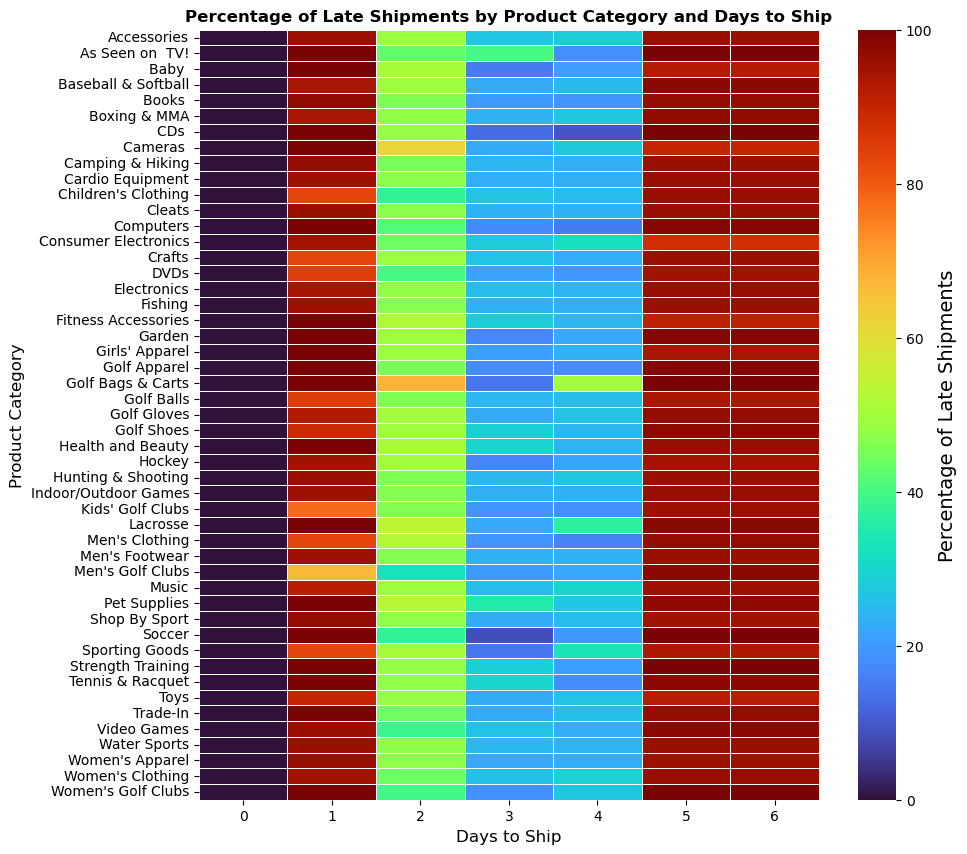

In [37]:
plt.figure(figsize=(10, 10))
ax = sns.heatmap(shipping_pivot_pct, annot=False, cmap="turbo", linewidths=.5, cbar_kws={'label': 'Percentage of Late Shipments'})
ax.collections[0].colorbar.set_label('Percentage of Late Shipments', fontsize=14)
ax.set_title('Percentage of Late Shipments by Product Category and Days to Ship', fontweight='bold', fontsize=12)
ax.set_xlabel('Days to Ship', fontsize=12)
ax.set_ylabel('Product Category', fontsize=12)

In [38]:
xxx

NameError: name 'xxx' is not defined

In [ ]:
%store -r sc_customers
%store -r sc_products
%store -r sc_categories_departments
%store -r sc_orders
%store -r sc_orders_ratio
%store -r sc_orders_demographic
%store -r sc_shipping

In [ ]:
fig = plt.figure(figsize=(8, 10), dpi=144)

ax1 = fig.add_subplot(4, 2, 1)
shipping_pivot_0[shipping_pivot_0['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_not_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'], ax=ax1)
ax1.set_xlabel('Product Categories', fontsize=12)
ax1.set_ylabel('Number of Shipments', fontsize=12)
ax1.tick_params(labelsize=8, labelbottom=True)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
ax1.legend(title='Delivery Status', labels=['Late', 'Not Late'], title_fontsize=10, fontsize=10)

plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 10), dpi=144)

ax1 = fig.add_subplot(4, 2, 1)
shipping_pivot_all[shipping_pivot_all['n_late'] > 500][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'], ax=ax1)
ax1.set_title('All Shipping Days', fontweight="bold")
ax1.set_xlabel('Product Categories', fontsize=12)
ax1.set_ylabel('Number of Shipments', fontsize=12)
ax1.tick_params(labelsize=8, labelbottom=True)
ax1.set_xticks([])
ax1.legend('')

ax2 = fig.add_subplot(4, 2, 2)
shipping_pivot_0[shipping_pivot_0['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_not_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'], ax=ax2)
ax2.set_title('All Shipping Days', fontweight="bold")
ax2.set_xlabel('Product Categories', fontsize=12)
ax2.set_ylabel('Number of Shipments', fontsize=12)
ax2.tick_params(labelsize=8, labelbottom=True)
ax2.set_xticks([])
ax2.legend('')

ax3 = fig.add_subplot(4, 2, 3)
shipping_pivot_1[shipping_pivot_1['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'], ax=ax3)
ax3.set_title('All Shipping Days', fontweight="bold")
ax3.set_xlabel('Product Categories', fontsize=12)
ax3.set_ylabel('Number of Shipments', fontsize=12)
ax3.tick_params(labelsize=8, labelbottom=True)
ax3.set_xticks([])
ax3.legend('')

ax4 = fig.add_subplot(4, 2, 4)
shipping_pivot_2[shipping_pivot_2['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'], ax=ax4)
ax4.set_title('All Shipping Days', fontweight="bold")
ax4.set_xlabel('Product Categories', fontsize=12)
ax4.set_ylabel('Number of Shipments', fontsize=12)
ax4.tick_params(labelsize=8, labelbottom=True)
ax4.set_xticks([])
ax4.legend('')

ax5 = fig.add_subplot(4, 2, 5)
shipping_pivot_3[shipping_pivot_3['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'], ax=ax5)
ax5.set_title('All Shipping Days', fontweight="bold")
ax5.set_xlabel('Product Categories', fontsize=12)
ax5.set_ylabel('Number of Shipments', fontsize=12)
ax5.tick_params(labelsize=8, labelbottom=True)
ax5.set_xticklabels(ax5.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
ax5.set_xticks([])
ax5.legend('')

ax6 = fig.add_subplot(4, 2, 6)
shipping_pivot_4[shipping_pivot_4['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'], ax=ax6)
ax6.set_title('All Shipping Days', fontweight="bold")
ax6.set_xlabel('Product Categories', fontsize=12)
ax6.set_ylabel('Number of Shipments', fontsize=12)
ax6.tick_params(labelsize=8, labelbottom=True)
ax6.set_xticklabels(ax6.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
ax6.set_xticks([])
ax6.legend('')

plt.show()

In [ ]:
fig = plt.figure(figsize=(8, 10),dpi=144)

ax1 = fig.add_subplot(4, 2, 1)
ax1.pie(shipping_pie['0_days_to_ship'].drop(index=[4, 2, 0]), autopct='%1.1f%%', startangle=90, colors=['grey', '#22A3CF'], labels=['Cancelled', 'On Time'])
ax1.set_title('0 Days to Ship', fontsize=12, fontweight='bold')


fig = plt.figure(figsize=(8, 10),dpi=144)

ax1 = fig.add_subplot(4, 2, 1)
ax1.plot(data=shipping_pivot_all[shipping_pivot_all['n_late'] > 500][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False), kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'])
ax1.set_title('All Shipping Days', fontweight="bold")
ax1.set_xlabel('Product Categories', fontsize=12)
ax1.set_ylabel('Number of Shipments', fontsize=12)
ax1.tick_params(labelsize=8, labelbottom=True)
ax1.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
ax1.legend(title='Delivery Status', labels=['Late', 'Not Late'], title_fontsize=10, fontsize=10)

ax2 = fig.add_subplot(4, 2, 2)
ax3 = fig.add_subplot(4, 2, 3)
ax4 = fig.add_subplot(4, 2, 4)
ax5 = fig.add_subplot(4, 2, 5)
ax6 = fig.add_subplot(4, 2, 6)
ax7 = fig.add_subplot(4, 2, 7)

In [ ]:
ax = shipping_pivot_all[['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'])

ax.set_title('All Shipping Days', fontweight="bold")
ax.set_xlabel('Product Categories')
ax.set_ylabel('Number of Shipments')
ax.tick_params(labelsize=8, labelbottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(title='Delivery Status', labels=['Late', 'Not Late'], title_fontsize=10, fontsize=10)

plt.show()

In [ ]:
ax = shipping_pivot_all[shipping_pivot_all['n_late'] > 500][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'])

ax.set_title('All Shipping Days', fontweight="bold")
ax.set_xlabel('Product Categories', fontsize=12)
ax.set_ylabel('Number of Shipments', fontsize=12)
ax.tick_params(labelsize=8, labelbottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=12)
ax.legend(title='Delivery Status', labels=['Late', 'Not Late'], title_fontsize=10, fontsize=10)

plt.show()

In [ ]:
ax = shipping_pivot_0[shipping_pivot_0['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_not_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'])

ax.set_title('All Shipping Days', fontweight="bold")
ax.set_xlabel('Product Categories')
ax.set_ylabel('Number of Shipments')
ax.tick_params(labelsize=8, labelbottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(title='Delivery Status', labels=['Late', 'Not Late'], title_fontsize=10, fontsize=10)

plt.show()

In [ ]:
ax = shipping_pivot_1[shipping_pivot_1['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'])

ax.set_title('All Shipping Days', fontweight="bold")
ax.set_xlabel('Product Categories')
ax.set_ylabel('Number of Shipments')
ax.tick_params(labelsize=8, labelbottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(title='Delivery Status', labels=['Late', 'Not Late'], title_fontsize=10, fontsize=10)

plt.show()

In [ ]:
ax = shipping_pivot_2[shipping_pivot_2['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'])

ax.set_title('All Shipping Days', fontweight="bold")
ax.set_xlabel('Product Categories')
ax.set_ylabel('Number of Shipments')
ax.tick_params(labelsize=8, labelbottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(title='Delivery Status', labels=['Late', 'Not Late'], title_fontsize=10, fontsize=10)

plt.show()

In [ ]:
ax = shipping_pivot_3[shipping_pivot_3['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'])

ax.set_title('All Shipping Days', fontweight="bold")
ax.set_xlabel('Product Categories')
ax.set_ylabel('Number of Shipments')
ax.tick_params(labelsize=8, labelbottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(title='Delivery Status', labels=['Late', 'Not Late'], title_fontsize=10, fontsize=10)

plt.show()

In [ ]:
ax = shipping_pivot_4[shipping_pivot_4['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'])

ax.set_title('All Shipping Days', fontweight="bold")
ax.set_xlabel('Product Categories')
ax.set_ylabel('Number of Shipments')
ax.tick_params(labelsize=8, labelbottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(title='Delivery Status', labels=['Late', 'Not Late'], title_fontsize=10, fontsize=10)

plt.show()

In [ ]:
ax = shipping_pivot_5[shipping_pivot_5['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'])

ax.set_title('All Shipping Days', fontweight="bold")
ax.set_xlabel('Product Categories')
ax.set_ylabel('Number of Shipments')
ax.tick_params(labelsize=8, labelbottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(title='Delivery Status', labels=['Late', 'Not Late'], title_fontsize=10, fontsize=10)

plt.show()

In [ ]:
ax = shipping_pivot_6[shipping_pivot_6['total'] > 200][['category', 'n_late', 'n_not_late']].sort_values('n_late', ascending=False).plot(kind='bar', x='category', figsize=(10, 6), width=0.8, color=['#E82727', '#43BC41'])

ax.set_title('All Shipping Days', fontweight="bold")
ax.set_xlabel('Product Categories')
ax.set_ylabel('Number of Shipments')
ax.tick_params(labelsize=8, labelbottom=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(title='Delivery Status', labels=['Late', 'Not Late'], title_fontsize=10, fontsize=10)

plt.show()

In [ ]:
xxx

In [ ]:
sns.lmplot(x='days_shipping_real', y='risk', hue='category_id', data=sc_shipping.merge(sc_products, on='product_id'))
plt.title('Relationship between Days Shipping Real and Risk by Product Category')
plt.show()

In [ ]:
ax = shipping_merge.drop('total', axis=1).plot(kind='bar', x='days_shipping_real', stacked=False, figsize=(10, 6), width=0.8, color=['yellow', 'green', 'red', 'grey'])

plt.title('Shipping Status by Days to Ship', fontsize=15, fontweight='bold')
plt.xlabel('Days to Ship', fontsize=12)
plt.ylabel('Number of Shipments', fontsize=12)
plt.legend(title='Delivery Status', labels=['Advanced', 'On Time', 'Late', 'Cancelled'], title_fontsize=10, fontsize=10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=360, horizontalalignment='right', fontsize=12)
plt.yticks(fontsize=12)

for p in ax.patches:
    height = p.get_height()
    if height != 0:
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', xytext=(0, 6), textcoords='offset points', fontsize=12)

In [ ]:
ax = shipping_merge.drop('total', axis=1).plot(kind='bar', stacked=False, colormap='PuOr', figsize=(10, 6))

plt.title('Shipping Status by Days to Shipping')
plt.xlabel('Days to Ship')
plt.ylabel('Number of Orders')

legend_colors = ['blue', 'green', 'orange', 'red', 'purple']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]

plt.legend(title='Delivery Status', labels=['Advanced', 'On Time', 'Late', 'Cancelled'], handles=handles)

In [ ]:
ax = shipping_merge.drop('total', axis=1).plot(kind='bar', stacked=False, figsize=(10, 6))

plt.title('Shipping Status by Days to Shipping')
plt.xlabel('Days to Ship')
plt.ylabel('Number of Orders')

legend_colors = ['blue', 'green', 'red', 'black']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]

plt.legend(title='Delivery Status', labels=['Advanced', 'On Time', 'Late', 'Cancelled'], handles=handles)

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a DataFrame with the provided data
data = {
    'days_shipping_real': [0, 1, 2, 3, 4, 5, 6],
    'total': [5080, 4657, 56618, 28765, 28513, 28163, 28723],
    'n_advanced': [0, 0, 20873, 20719, 0, 0, 0],
    'n_on_time': [4839, 0, 6819, 0, 20538, 0, 0],
    'n_late': [241, 203, 2413, 1287, 1216, 1160, 1234],
    'n_cancelled': [0, 4454, 26513, 6759, 6759, 27003, 27489]
}

df = pd.DataFrame(data)

# Set the 'days_shipping_real' column as the index for plotting
df.set_index('days_shipping_real', inplace=True)

# Plot the data using a grouped bar plot with custom colors
ax = df.plot(kind='bar', colormap=['blue', 'green', 'orange', 'red', 'purple'], figsize=(10, 6))

# Add labels and title
plt.xlabel('Days to Shipping')
plt.ylabel('Count')
plt.title('Shipping Status by Days to Shipping')

# Custom legend with specific colors
legend_labels = ['Total', 'Advanced', 'On Time', 'Late', 'Cancelled']
legend_colors = ['blue', 'green', 'orange', 'red', 'purple']
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in legend_colors]
ax.legend(handles=handles, labels=legend_labels, title='Status', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


# Request 2
## Conduct a comprehensive time-series analysis of the sales data over the entire dataset duration.
## Identify any seasonality patterns, trends, or anomalies in the sales performance. 
## Furthermore, assess the impact of different marketing campaigns or promotions by correlating the dates of special promotions with spikes or dips in sales. 
## Provide actionable insights for optimizing future marketing strategies based on the historical sales patterns."

In [ ]:
sc_orders

In [ ]:
sns.lineplot(data=sc_orders, x='order_date', y=sc_orders['price'].sum())

In [ ]:
sc_orders['price'].sum()

In [ ]:
sc_orders['order_date'].describe()

In [ ]:
sc_orders.groupby('price')['order_date'].mean().reset_index()

In [ ]:
sns.lineplot(data=sc_orders.groupby('price')['order_date'].mean().reset_index(), x='order_date', y='price')

In [ ]:
sc_orders.columns.tolist()

In [ ]:
table = sc_orders[['transaction_id', 'order_id', 'order_date', 'price', 'net_sale']]
table

In [ ]:
table['order_date'].dt.date.reset_index()

In [ ]:
table

In [ ]:
table['yyyy_mm_dd'] = table['order_date'].dt.date.astype(str)
table

In [ ]:
table.loc['date_only'] = table['order_date'].dt.date.astype(str)